In [1]:
import json
import os
from ast import literal_eval
from pathlib import Path 
import os

# reads in minion statistics and returns dictionary
def readMinionStats(pathToFile):
    stats = open(pathToFile, "r")
    statTypeLoc = 0
    statValLoc = 1
    lines = stats.readlines()
    statsDict = {}
    for line in lines:
        line = line.split(":")
        if len(line) <= 1: 
            continue
        statsDict[line[statTypeLoc]] = literal_eval(line[statValLoc])
    return statsDict

# reads in minizinc file, places stats into statDict
# and solution into solutionDict
def readMinizinc(pathToFile, statDict, solutionDict):
    miniStats = open(pathToFile, "r")
    lines = miniStats.readlines()
    # failed to run
    if len(lines) == 0 or "driver" in lines[0]:
        return
    statDict["timeout"] = False
    for line in lines:
        lineJson = json.loads(line)
        lineType = lineJson["type"]
        if lineType == "statistics":
            statDict.update(lineJson["statistics"])
            if "solveTime" in lineJson["statistics"] and lineJson["statistics"]["solveTime"] >= timeoutTimeSecs:
                statDict["timeout"] = True
        elif lineType == "solution":
            solutionDict.update(lineJson["output"]["json"])
        elif lineType == "comment" and lineJson["comment"] == "% Time limit exceeded!":
            statDict["timeout"] = True

timeoutTimeSecs = 3600 # default timeout time, otherwise read from timout
with open(str(Path().resolve()) + "/../../bash/constants/timeout.txt", "r") as timeout_file:
    timeout_millisecs = timeout_file.readline()
    timeoutTimeSecs = int(literal_eval(timeout_millisecs)/1000)
print('timeout set in seconds as', timeoutTimeSecs)

num_runs = 3 # default num runs
median_location = 1 # default median
with open(str(Path().resolve()) + "/../../bash/constants/randomSeeds.txt", "r") as num_runs_file:
    rand_nums = num_runs_file.readlines()
    num_runs = len(rand_nums)
    median_location = num_runs//2
print('number of runs set as ', num_runs)

# gets the data from statFile path
def fetch_data(statFile, isEprime):
    statInfo = {}
    if isEprime:
        # .info files
        statInfo = readMinionStats(statFile)
    else:
        miniSolution = {}
        readMinizinc(statFile, statInfo, miniSolution)
    return statInfo

timeout set in seconds as 3600
number of runs set as  3


In [2]:
import statistics

dataLocation = "../../instances_and_solutions/"

wordpress = "wordpress"
wordpressNoSymm = "wordpressNoSymm"
quasigroup = "quasigroup"
quasigroupOcc = "quasigroupOcc"
tournament = "tournament"
tournamentFree = "tournamentFree"
mspsp = "mspsp"
cvrptw = "cvrptw"
roster = "roster"
rosterFree = "rosterFree"


    
# biggest_deviation = 0 # LEGACY debug

stdDevLoc = "stdDev"

# solvers = ["chuffed", "gecode"]
solvers = ["chuffed"]
# problemFlags = ["noFree", "free"]
problemFlags = ["free"]
optimisations = ["O0_S0", "O2_S1", "O3_S2"]
mzn_optimisations = ["O0", "O1", "O5"]
dataKeys = ["time", "solveTime", "initTime", "timeout"]
problemNames = [quasigroup, quasigroupOcc, wordpress, wordpressNoSymm, tournament, mspsp, cvrptw, roster]
noOccProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, tournament, mspsp, cvrptw, rosterFree, roster]
originalProblems = [quasigroup, wordpress, wordpressNoSymm, tournament, mspsp, cvrptw, roster]
freeOriginalProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, mspsp, cvrptw, rosterFree]

failed_runs = ["4", "5"] # TODO remove in future

problems = []
for name in problemNames:
    for slver in solvers:
        for flag in problemFlags:
            problems.append(name + "_" + flag + "_" + slver)

freeProblems = [x for x in problems if "_free_" in x]
# noFreeProblems = [x for x in problems if "_noFree_" in x]
chuffedProblems = [x for x in problems if "chuffed" in x]
# gecodeProblems = [x for x in problems if "gecode" in x]

# print(problems)
# print(noFreeProblems)
# print(freeProblems)
# print(chuffedProblems)
# print(gecodeProblems)

eprimePath = "/eprime/"
minizincPath = "/minizinc/"

# gets the median from the inputted runs array
# calculates the standard deviation as well
def getMedianStdev(runs):
    # global biggest_deviation
    # sort runs by overall time
    sortedLst = sorted(runs, key=lambda x: x["time"])
    res = sortedLst[median_location].copy()

    for key in dataKeys:
        # res[key] = statistics.mean([rn[key] for rn in runs])
        if key != "timeout":
            res[key + "_stdev"] = statistics.stdev([rn[key] for rn in runs])
            res[key + "_mean"] = statistics.mean([rn[key] for rn in runs])
        res[key + "_all_runs"] = [rn[key] for rn in runs]
    return res

def dummyDataValue(data):
    data["timeout"] = True
    data["initTime"] = 0.5 # TODO dummy value
    data["time"] = timeoutTimeSecs
    return data

def getData(path, isEprime):
    runs = []
    # path is path to instance directory
    # generate run (ie. 3 instance files) data
    # returns the median of the 3 runs
    for entry in os.scandir(path):

        if os.path.isdir(entry) or any(["run" + i in entry.path for i in failed_runs]):
            continue
        data = fetch_data(entry.path, isEprime)
        if isEprime:
            # stadardises data to minizinc format
            data = processEprime(data)
        # case of unknown message, ex. quasigroupOcc.mzn run on instance 50.json
        elif 'time' not in data:
            data = dummyDataValue(data)
        if data["timeout"]:
            data["solveTime"] = timeoutTimeSecs
            data["time"] = timeoutTimeSecs
        
        runs.append(data)

    if len(runs) > 0:
       return getMedianStdev(runs)
    else:
        return {}


# stadardises data to minizinc format
def processEprime(data):
    d = {}
    if 'SolverTotalTime' not in data:
        return dummyDataValue(d)
    d["time"] = data['SolverTotalTime'] + data['SavileRowTotalTime']        
    d["solveTime"] = data['SolverTotalTime']
    d["initTime"] = data['SavileRowTotalTime']
    d["timeout"] = data['SolverTimeOut'] == 1
    # gecode does not give timeout
    if d["time"] >= timeoutTimeSecs:
        d["time"] = timeoutTimeSecs
        d["timeout"] = True
    return d

# eprime dictionary
# eprimeData[problemName_free/NoFree_chuffed/gecode][opt][(instanceName, values)]
eprimeData = {}
# minizinc dictionary
# minizincData[problemName_free/NoFree_chuffed/gecode][opt][(instanceName, values)]
minizincData = {}

# extract eprime 
def extract_eprime(problemLocation, folder_name, problemIndex):
    opt = {}
    eprimeProblemLocation = problemLocation + eprimePath + folder_name +"/timing"
    # for each optimization folder
    for optimize in os.scandir(eprimeProblemLocation):
        if optimize.name == "infor":
            continue
        res = []
        for problem in os.scandir(optimize.path):
            res.append((problem.name, getData(problem.path, True)))
        opt[optimize.name] = res
    eprimeData[problemIndex] = opt

# extracts all instance files for a problem into minizincData
def extract_mzn(problemLocation, folder_name, problemIndex):
    opt = {}
    mzn_path_to_scan = problemLocation + minizincPath + folder_name
    for optimisations in os.scandir(mzn_path_to_scan):
        res = []
        for problem in os.scandir(optimisations.path):
            # for each instance name
            if os.path.isdir(problem.path) and problem.name != "json":
                res.append((problem.name, getData(problem.path, False)))
        opt[optimisations.name] = res
    minizincData[problemIndex] = opt

########## EXPORTING THE DATA FOR FURTHER GRAPHS IF NEEDED ############
# exports the eprime data to json to 
# use in the objective graphs
# def export_data():
#     # Serializing json
#     json_object = json.dumps(eprimeData, indent=4) 
#  
#     with open("eprime_data.json", "w") as outfile:
#         outfile.write(json_object)
#######################################################################

for i in problemNames:
    for flag in problemFlags:
        for solver in solvers:
            print(i, flag)
            folder_name = flag + "_" + solver
            problemLocation = dataLocation + i 
            # ex. quasigroup_free_chuffed
            problemIndex = i + "_" + flag + "_" + solver
            extract_eprime(problemLocation, folder_name, problemIndex)
            extract_mzn(problemLocation, folder_name, problemIndex)

# print(biggest_deviation)
######### EXPORTING DATA ##############
# export_data() 
#######################################
print(eprimeData)
print(minizincData)

quasigroup free
quasigroupOcc free
wordpress free
wordpressNoSymm free
tournament free
mspsp free
cvrptw free
roster free
{'quasigroup_free_chuffed': {'O0_S0': [('qwh-o30-h374-02.dzn.param', {'time': 2.984, 'solveTime': 2.429, 'initTime': 0.555, 'timeout': False, 'time_stdev': 1798.508666708615, 'time_mean': 902.237, 'time_all_runs': [2.967, 3600, 2.984, 2.997], 'solveTime_stdev': 1798.7796667360346, 'solveTime_mean': 901.8305, 'solveTime_all_runs': [2.43, 3600, 2.429, 2.463], 'initTime_stdev': 0.022956480566498013, 'initTime_mean': 0.5315000000000001, 'initTime_all_runs': [0.537, 0.5, 0.555, 0.534], 'timeout_all_runs': [False, True, False, False]}), ('qwh-o30-h374-01.dzn.param', {'time': 2.5810000000000004, 'solveTime': 2.047, 'initTime': 0.534, 'timeout': False, 'time_stdev': 0.0830501856309382, 'time_mean': 2.619666666666667, 'time_all_runs': [2.5810000000000004, 2.715, 2.563], 'solveTime_stdev': 0.021197484127446094, 'solveTime_mean': 2.0503333333333336, 'solveTime_all_runs': [2.04

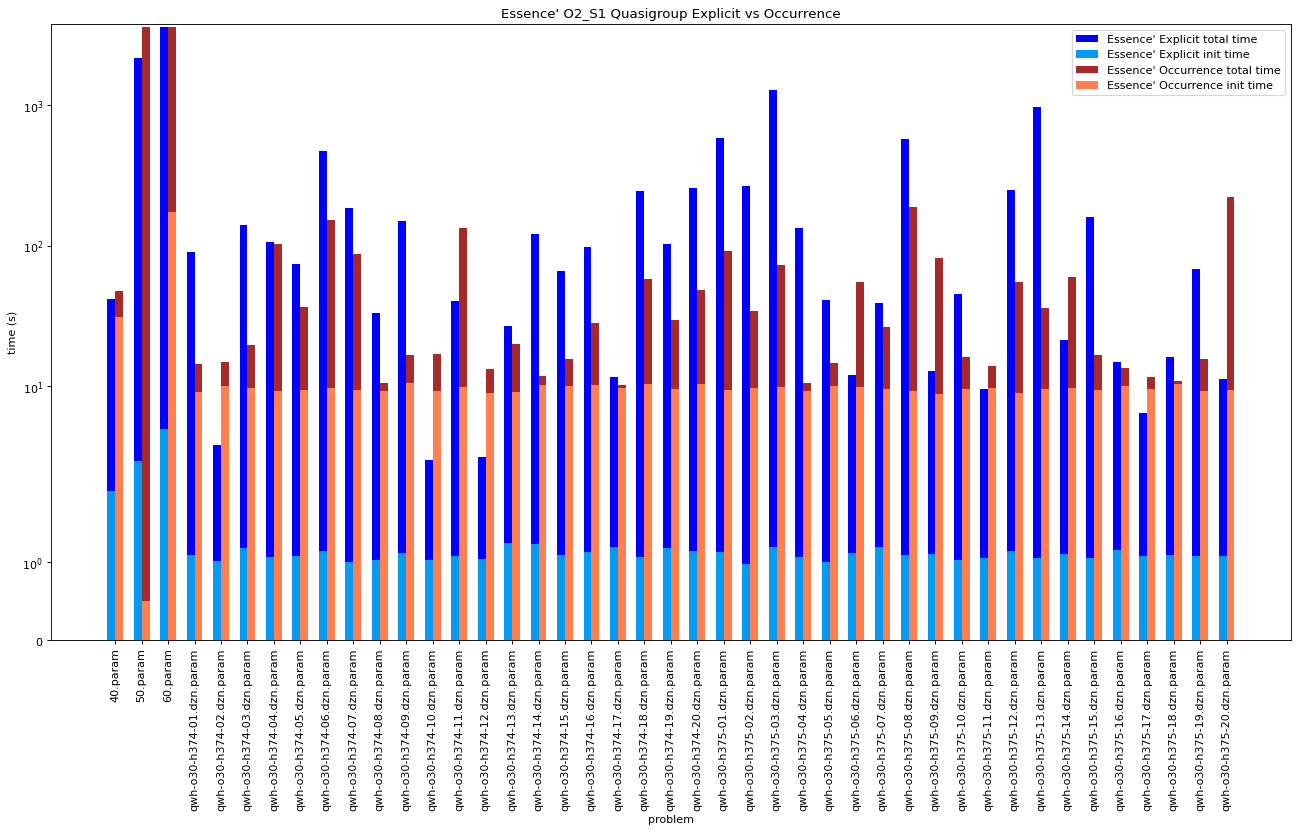

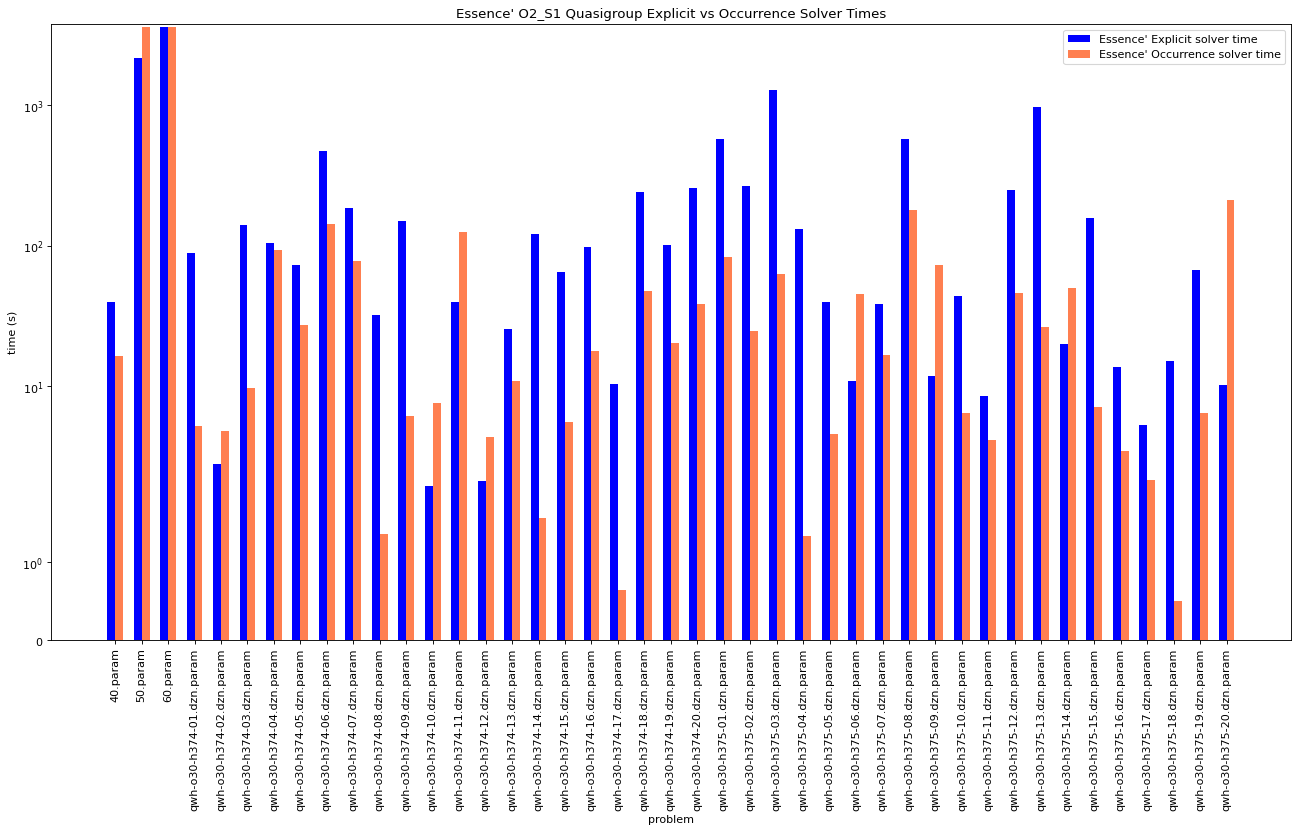

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

# TODO why use an index here than the naming convention already created?
def getData(dataToExtract):
    # sorts by the problem name
    xData, yData = zip(*sorted(dataToExtract))
    extractedY = []
    for i in dataKeys:
        extractedY.append(list(map(lambda y : y[i], yData)))
        if i != "timeout":
            extractedY.append(list(map(lambda y : y[i+"_stdev"], yData)))
    return (xData, *extractedY)


# TODO move after data processing into indexes so this is not a massive list
eprimeX, eprimeTime, eprimeTimeStdDev, eprimeSolverTime, eprimeSolverTimeStd, eprimeInit, eprimeInitStd, eprimeCompleted = getData(eprimeData["quasigroup_free_chuffed"]["O2_S1"])
eprimeOccX, eprimeOccTime, eprimeOccTimeStd, eprimeOccSolverTime, eprimeOccSolverStd, eprimeOccInit, eprimeOccInitStd, eprimeOccCompleted = getData(eprimeData["quasigroupOcc_free_chuffed"]["O2_S1"])

eprimeX = list(map(str, eprimeX))
eprimeOccX = list(map(str, eprimeOccX))

ind = np.arange(len(eprimeX))
width = 0.3

figure(figsize=(20, 10), dpi=80)
plt.title("Essence' O2_S1 Quasigroup Explicit vs Occurrence")
plt.bar(ind, eprimeTime, width, label="Essence' Explicit total time", color="blue")
plt.bar(ind, eprimeInit, width, label="Essence' Explicit init time",  color="#069AF3")
# plt.bar(ind+width, eprimeOccTime, width, label="MiniZinc", color="red")
# plt.bar(ind+width, eprimeOcc, width, label="MiniZinc init time" , color="maroon")
plt.bar(ind+width, eprimeOccTime, width, label="Essence' Occurrence total time", color="brown")
plt.bar(ind+width, eprimeOccInit, width, label="Essence' Occurrence init time", color="coral")
# plt.scatter(eprimeX, eprimeY, label="eprime")
# plt.scatter(eprimeOccX, minizincY, label="minizinc")
plt.legend(loc="best")
plt.xticks(ind+width/2, eprimeOccX)
plt.xticks(rotation = 90)
plt.xlabel("problem")
plt.ylabel("time (s)")
plt.yscale("symlog")


figure(figsize=(20, 10), dpi=80)
plt.title("Essence' O2_S1 Quasigroup Explicit vs Occurrence Solver Times")
plt.bar(ind, eprimeSolverTime, width, label="Essence' Explicit solver time", color="blue")
plt.bar(ind+width, eprimeOccSolverTime, width, label="Essence' Occurrence solver time", color="coral")
# plt.scatter(eprimeX, eprimeY, label="eprime")
# plt.scatter(eprimeOccX, minizincY, label="minizinc")
plt.legend(loc="best")
plt.xticks(ind+width/2, eprimeOccX)
plt.xticks(rotation = 90)
plt.xlabel("problem")
plt.ylabel("time (s)")
plt.yscale("symlog")

In [4]:
import itertools

# allEprimeTimings[problem name][optimisation][index (ex. problemIndex)][index values]
allEprimeTimings = {}
allMinizincTimings = {}

# TODO why use an index here than the naming convention already created?
problemIndex = 0
timingIndex = 1
timingStdevIndex = 2
solverTimeIndex = 3
solverStdevIndex = 4
initIndex = 5
initIndexStdev = 6
timeoutIndex = 7

NUM_INDEXES = 8

titleNames = {}
titleNames[timingIndex] = "total time"
titleNames[timingStdevIndex] = "total time standard deviation" 
titleNames[solverTimeIndex] = "solver time"
titleNames[solverStdevIndex] = "solver time standard deviation"
titleNames[initIndex] = "initialization time"
titleNames[initIndexStdev] = "initialization time standard deviation"
titleNames[timeoutIndex] = "timeout"

# TODO why use an index here for access than the naming convention already created?
for i in problems:
    allMinizincTimings[i] = {}
    print(i)
    for mzn_opt in mzn_optimisations:
        allMinizincTimings[i][mzn_opt] = getData(minizincData[i][mzn_opt])
    allEprimeTimings[i] = {}
    for j in optimisations:
        allEprimeTimings[i][j] = getData(eprimeData[i][j])

# marker = itertools.cycle((',', '+', 'o', '*', '^', 'x', 's', 'v','2', 'd', 'H', 'X'))
marker = itertools.cycle(('v', 'o', 'P', 's'))

maxLine = []

def setupPlotSolverSolver(graphTitle="Minizinc vs Essence'", indexOfInterest=timingIndex, plotTimeout=True):
    # fig = plt.figure(figsize=(20, 20), dpi=80)
    figure(figsize=(10, 10), dpi=80)
    # ax = plt.axes()
    if plotTimeout: # plot the line showing 
        plt.plot([0, timeoutTimeSecs], [0, timeoutTimeSecs])
    plt.xlabel("time MiniZinc (s)")
    plt.ylabel("time Essence' (s)")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    plt.yscale("symlog")
    plt.xscale("symlog")
    plt.title(graphTitle + " " + titleNames[indexOfInterest])
    plt.rcParams['font.size'] = 14

def createOccurencePlot(opt, occProblem, explicitProblem, annotate=False, indexOfInterest=timingIndex, errorbars=False):
    x, y = occProblem[indexOfInterest], explicitProblem[indexOfInterest]
    # chosenColor = next(color)
    plt.xlabel("time occurrence (s)")
    plt.ylabel("time explicit (s)")
    # plt.scatter(x, y, label= quasigroup + " " + opt, marker=next(marker), color=chosenColor)
    plt.scatter(x, y, label=quasigroup + " " + opt, marker=next(marker))
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    maxLine.extend(x)
    maxLine.extend(y)
    if annotate:
        for j in range(len(occProblem[problemIndex])):
            plt.annotate(occProblem[problemIndex][j], (occProblem[indexOfInterest][j], explicitProblem[indexOfInterest][j]))
    if errorbars:
        stdDevLoc = indexOfInterest+1
        # plt.errorbar(x, y, yerr=explicitProblem[stdDevLoc], xerr=occProblem[stdDevLoc], ls='none', color=chosenColor, lw=1)
        plt.errorbar(x, y, yerr=explicitProblem[stdDevLoc], xerr=occProblem[stdDevLoc], ls='none', lw=1)



def createPlot(opt_index, problemList, annotate=False, errorbars=False, indexOfInterest=timingIndex):
    for i in problemList:
        m_opt = mzn_optimisations[opt_index]
        e_opt = optimisations[opt_index]
        minizincProblem = allMinizincTimings[i][m_opt]
        essenceProblem = allEprimeTimings[i][e_opt]
        x, y = minizincProblem[indexOfInterest], essenceProblem[indexOfInterest]
        maxLine.extend(x)
        maxLine.extend(y)
        # chosenColor = next(color)
        labels = i + " E-" + e_opt + " M-" + m_opt
        if errorbars:
            stdDevLoc = indexOfInterest+1
            plt.errorbar(x, y, yerr=essenceProblem[stdDevLoc], 
            xerr=minizincProblem[stdDevLoc], label=labels, fmt=next(marker), ls='none', lw=0.5, capsize=2)
        else:
            plt.scatter(x, y, label=labels, marker=next(marker))
        if annotate:
            for j in range(len(minizincProblem[problemIndex])):
                plt.annotate(minizincProblem[problemIndex][j], (minizincProblem[indexOfInterest][j], essenceProblem[indexOfInterest][j]))
        plt.xlim(left=0)
        plt.ylim(bottom=0)
    if len(problemList) == 1: # plotting only one problem, print out title
        plt.title("Minizinc vs Essence' " + problemList[0] + " " + titleNames[indexOfInterest])

def plotAllOpts(problemList, annotate=False, errorbars=False, indexOfInterest=timingIndex):
    for opt_index in range(len(optimisations)):
        createPlot(opt_index, problemList, annotate, errorbars, indexOfInterest)

# box = plt.get_position()
# plt.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc="best")

quasigroup_free_chuffed
quasigroupOcc_free_chuffed
wordpress_free_chuffed
wordpressNoSymm_free_chuffed
tournament_free_chuffed
mspsp_free_chuffed
cvrptw_free_chuffed
roster_free_chuffed


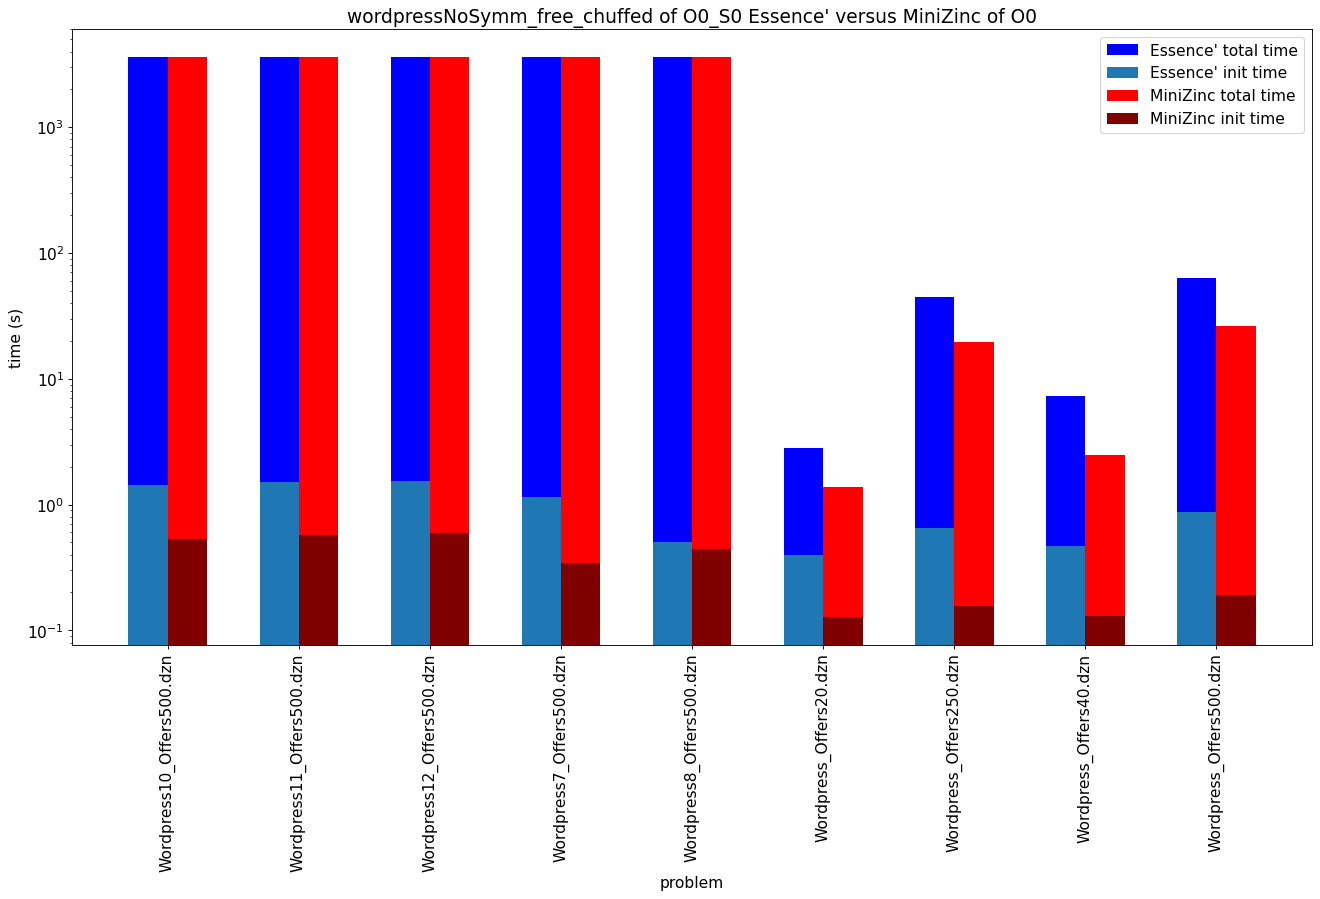

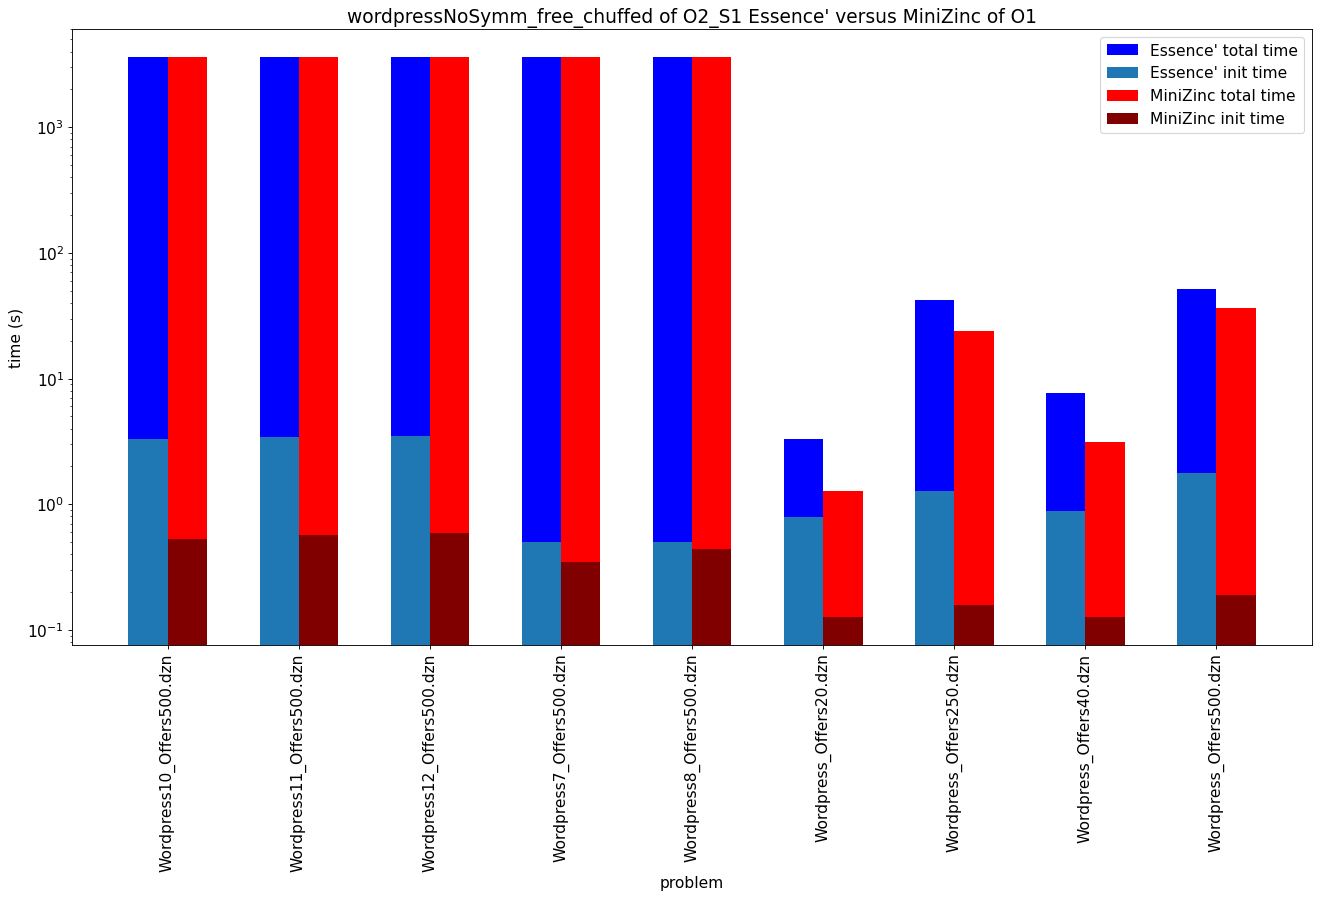

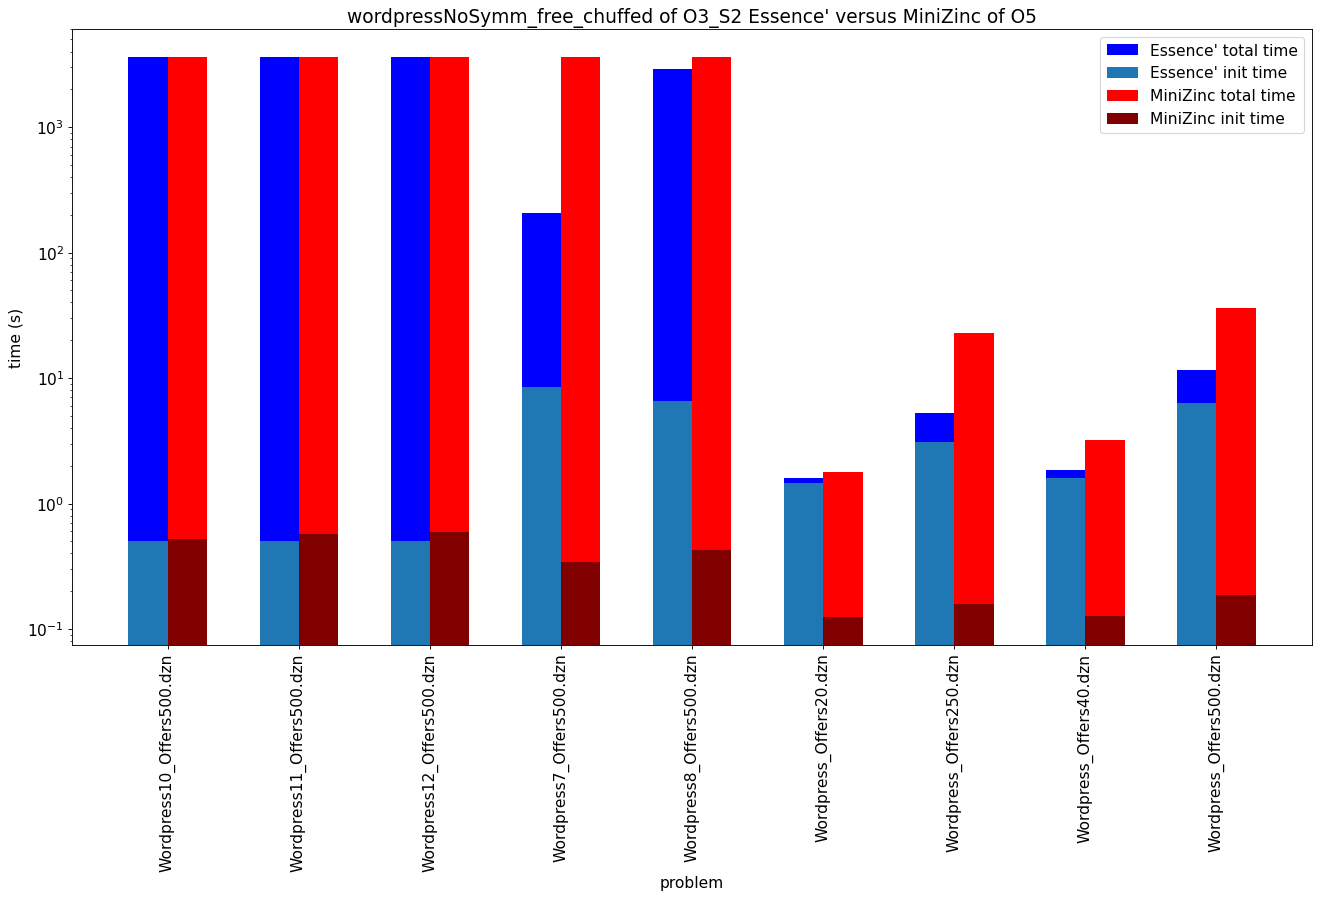

In [5]:

def createBarTimingsInit(opt_index, problem):
    eprime_opt = optimisations[opt_index]
    mzn_opt = mzn_optimisations[opt_index]
    ind = np.arange(len(allEprimeTimings[problem][eprime_opt][timingIndex]))
    width = 0.3
    figure(figsize=(20, 10), dpi=80)
    plt.rcParams['font.size'] = 14
    plt.bar(ind, allEprimeTimings[problem][eprime_opt][timingIndex], width, label="Essence' total time", color="blue")
    plt.bar(ind, allEprimeTimings[problem][eprime_opt][initIndex], width, label="Essence' init time")
    plt.bar(ind+width, allMinizincTimings[problem][mzn_opt][timingIndex], width, label="MiniZinc total time", color="red")
    plt.bar(ind+width, allMinizincTimings[problem][mzn_opt][initIndex], width, label="MiniZinc init time" , color="maroon")
    plt.legend(loc="best")
    plt.title(problem + " of " + eprime_opt + " Essence' versus MiniZinc of " + mzn_opt)
    plt.xticks(ind+width/2, allMinizincTimings[problem][mzn_opt][problemIndex])
    plt.xticks(rotation = 90)
    plt.xlabel("problem")
    plt.ylabel("time (s)")
    plt.yscale("log")

# for problem in chuffedProblems:
for problem in ["wordpressNoSymm_free_chuffed"]:
    for opt in range(len(optimisations)):
        createBarTimingsInit(opt, problem)

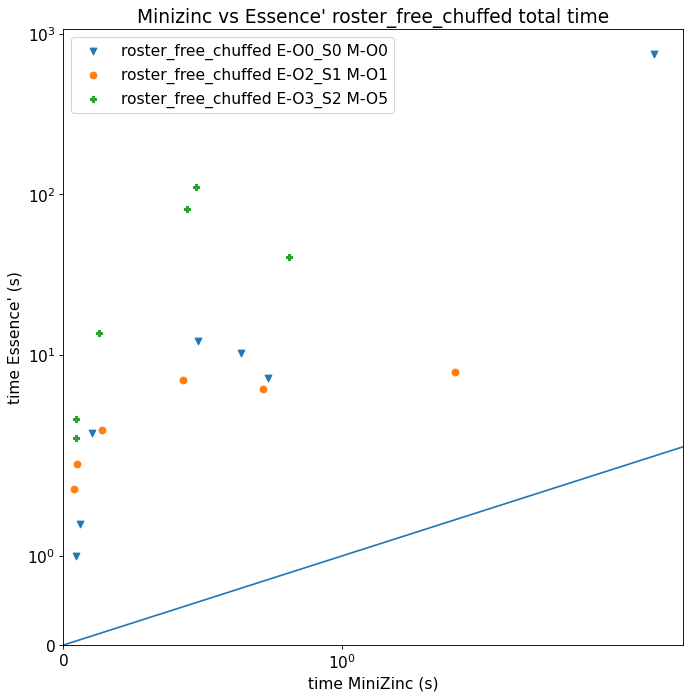

In [6]:
for p in ["roster_free_chuffed"]:
    setupPlotSolverSolver(plotTimeout=False)
    plotAllOpts([p])
    plt.legend(loc="best")
    end = [0, max(maxLine)]
    plt.plot(end, end)

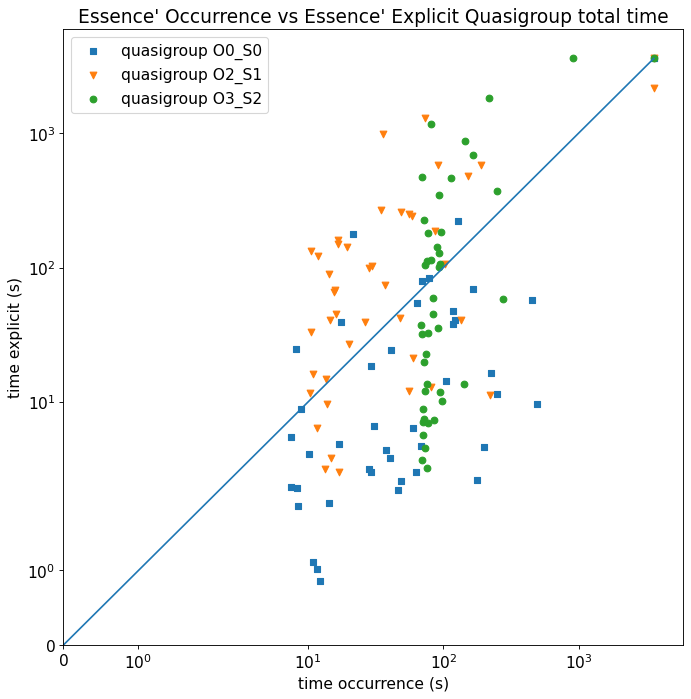

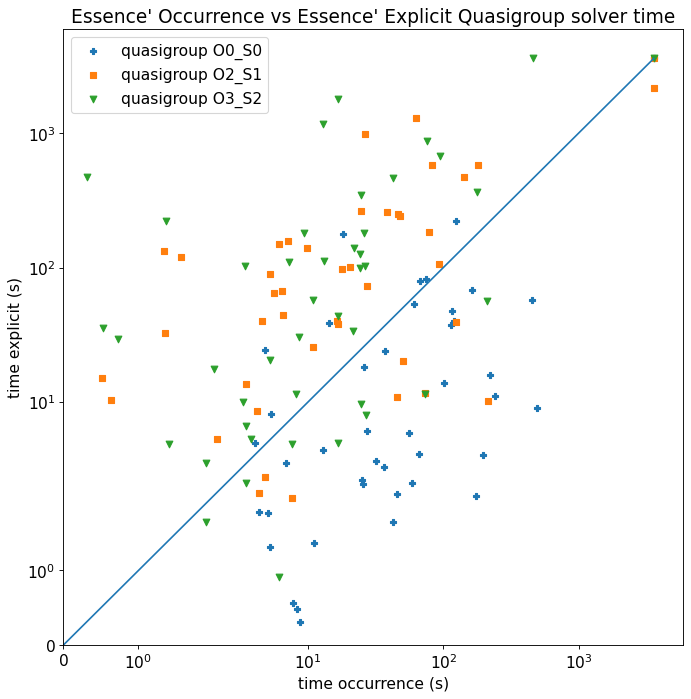

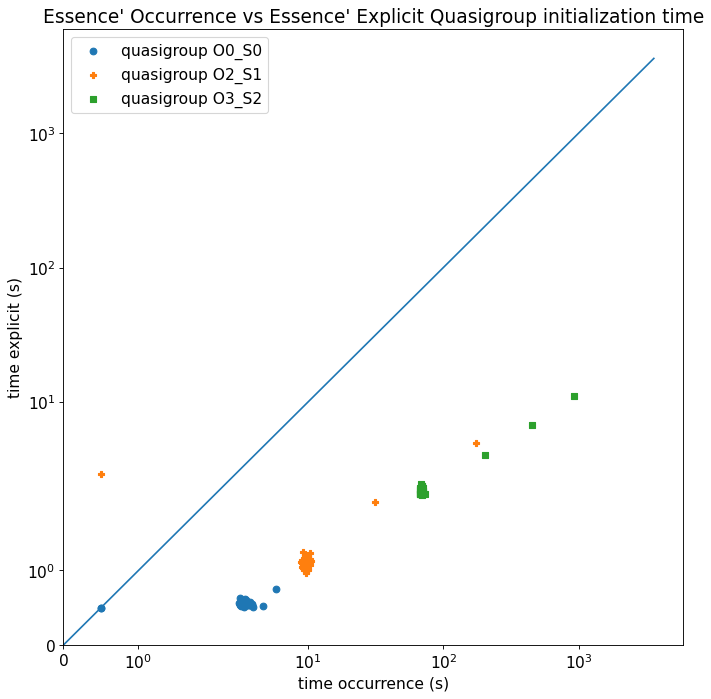

In [7]:
def occurrencePlot(index):
    setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup", index)
    for solver in ["chuffed"]:
        for flag in ["free"]:
            for j in optimisations:
                createOccurencePlot(j, allEprimeTimings[quasigroupOcc + "_" + flag + "_" + solver][j], allEprimeTimings[quasigroup  + "_" + flag + "_" + solver][j], indexOfInterest=index)
    plt.legend(loc="best")

occurrencePlot(timingIndex)
occurrencePlot(solverTimeIndex)
occurrencePlot(initIndex)

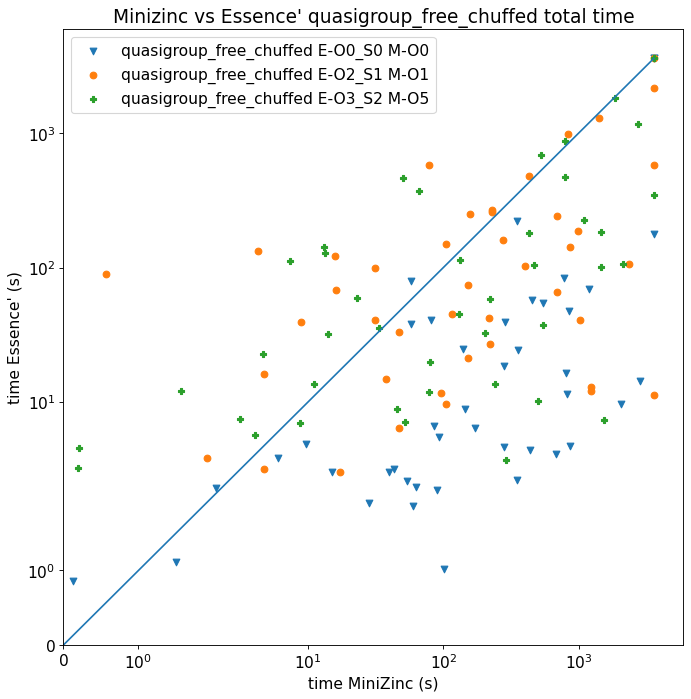

In [8]:
setupPlotSolverSolver()
plotAllOpts([quasigroup + "_free_chuffed"])
plt.legend(loc="best")

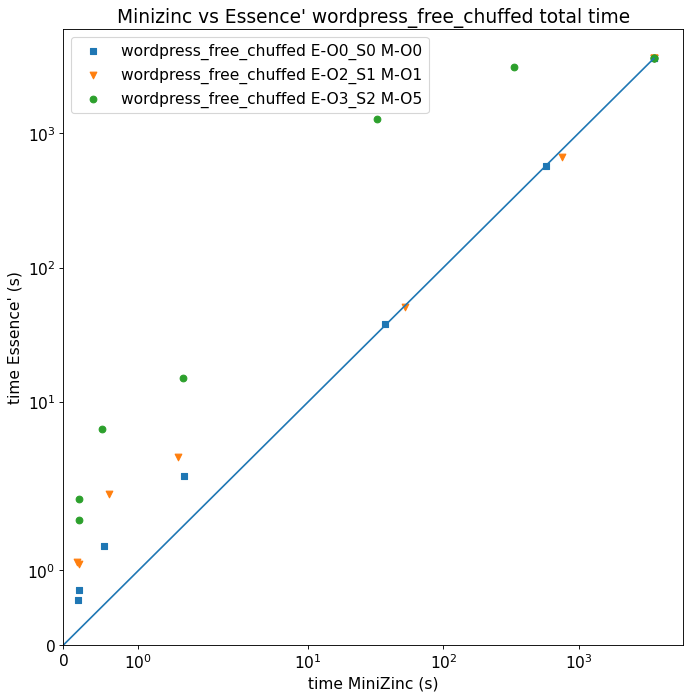

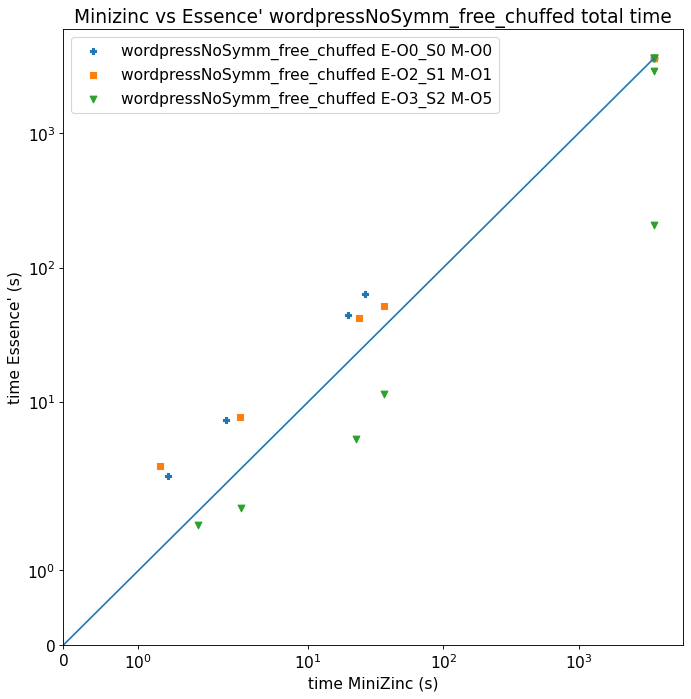

In [9]:
for i in [wordpress, wordpressNoSymm]:
    for j in ["_free_chuffed"]:
        setupPlotSolverSolver()
        plotAllOpts([i + j])
        plt.legend(loc="best")

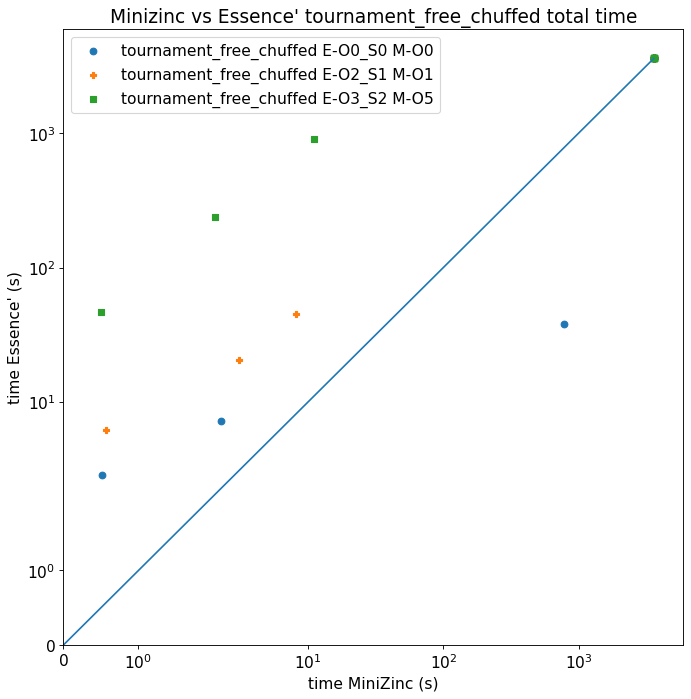

In [10]:
for i in ["_free_chuffed"]:
    setupPlotSolverSolver()
    plotAllOpts([tournament + i])
    plt.legend(loc="best")

(0.0, 116.5)

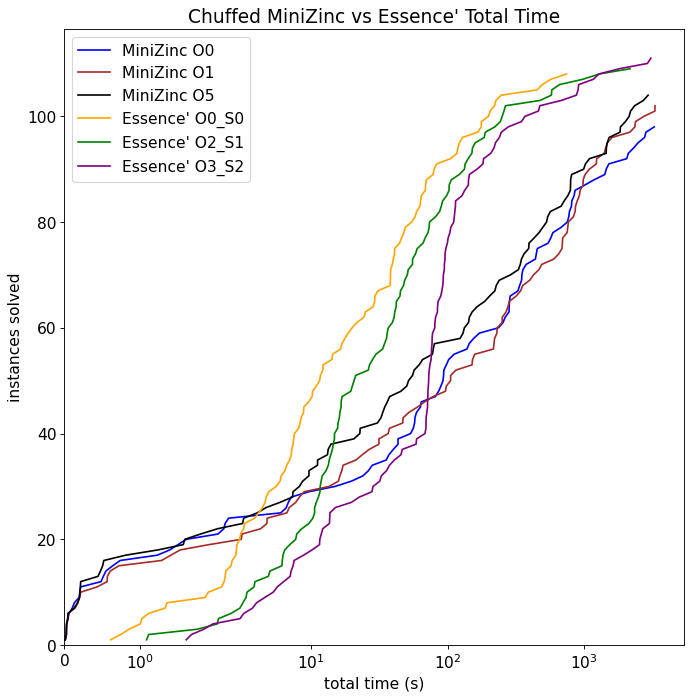

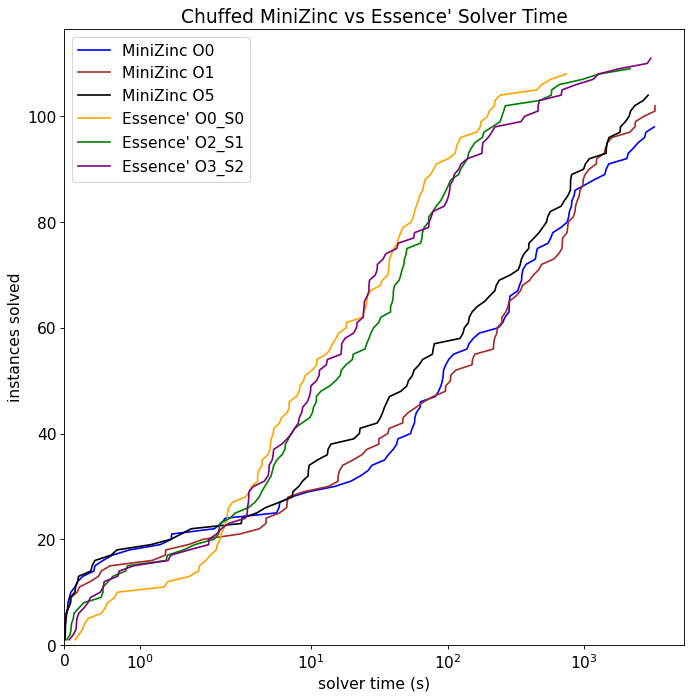

In [11]:
def setupCumulativePlot(title, axis_title):
    figure(figsize=(10, 10), dpi=80)
    plt.xlabel(axis_title)
    plt.ylabel("instances solved")
    plt.xscale("symlog")
    plt.title(title)
    plt.rcParams['font.size'] = 14

def createCumulativePlot(lst, opt, problemList=problems, label="Essence' ", color=None, markers=None, indexToGet=timingIndex):
    xValues = []
    allTimings = []
    for i in problemList:
        lstToGet = lst[i][opt]
        allTimings.extend([lstToGet[indexToGet][i] for i in range(len(lstToGet[indexToGet])) if not lstToGet[timeoutIndex][i]])
    allTimings.sort()
    # print(len(allTimings))
    yValues = [i for i in range(1, len(allTimings)+1)]
    xValues = allTimings
    plt.plot(xValues, yValues, label=label + (opt if opt else ""), color=color, marker=markers)
    plt.locator_params(axis="y", integer=True)
    
coloring = {}
# eprime colors
coloring["O0_S0"] = "orange"
coloring["O2_S1"] = "green"
coloring["O2_S2"] = "red"
coloring["O3_S2"] = "purple"
# mzn optimisation colors
coloring["O0"] = "blue"
coloring["O1"] = "brown"
coloring["O5"] = "black"

setupCumulativePlot("Chuffed MiniZinc vs Essence' Total Time", "total time (s)")
for mzn_opt in mzn_optimisations:
    createCumulativePlot(allMinizincTimings, mzn_opt, problemList=freeProblems, label="MiniZinc ", color=coloring[mzn_opt])

for opt in optimisations:
    createCumulativePlot(allEprimeTimings, opt, problemList=freeProblems, color=coloring[opt])
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)

setupCumulativePlot("Chuffed MiniZinc vs Essence' Solver Time", "solver time (s)")
for mzn_opt in mzn_optimisations:
    createCumulativePlot(allMinizincTimings, mzn_opt, problemList=freeProblems, label="MiniZinc ", color=coloring[mzn_opt], indexToGet=solverTimeIndex)
print()
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(allEprimeTimings, opt, problemList=freeProblems, color=coloring[opt], indexToGet=solverTimeIndex)
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)


In [12]:

# def getData(dataToExtract):
#     # sorts the data alphabetically
#     # unpacks the data
#     # zips the data into problemName, problemData 
#     xData, yData = zip(*sorted(dataToExtract))
#     extractedY = {}
#     for i in dataKeys:
#         extractedY[i] = ([y[i] for y in yData])
#         extractedY[i + "_all_runs"] = ([y[i + "_all_runs"] for y in yData])
#         # extractedY.append(list(map(lambda y : y[i], yData)))
#         if i != "timeout":
#             extractedY[i+"_CV"] = ([y[i+"_CV"] for y in yData])
#             # extractedY.append(list(map(lambda y : y[i+"_stdev"], yData)))
#     res = {}
#     res['instances'] = xData
#     res['data'] = extractedY 
#     return res

# eprimeDiffTimings = {}
# minizincDiffTimings = {}

# for i in problems:
#     minizincDiffTimings[i] = {}
#     for opt in mzn_optimisations:
#         minizincDiffTimings[i][opt] =  getData(minizincData[i][opt])
#     # print(minizincData[i])
#     # print()
#     eprimeDiffTimings[i] = {}
#     for j in optimisations:
#         eprimeDiffTimings[i][j] = getData(eprimeData[i][j])
    

In [19]:
def table_header_print():
    print('Problem,O0_S0/O0,O2_S1/O1,O3_S2/O5')

def get_problem_name(problem_name):
    return problem_name.split("_")[0]

print('Problem (number of instances),O0_S0|O0,O2_S1|O1,O3_S2|O5')
for problem in problems:
    num_instances = len(allMinizincTimings[problem][mzn_optimisations[0]][problemIndex])
    to_join = [get_problem_name(problem) + ' (' + str(num_instances) + ')']
    for opt in range(len(optimisations)):
        num_mzn_timeouts = allMinizincTimings[problem][mzn_optimisations[opt]][timeoutIndex].count(False)
        num_eprime_timeouts = allEprimeTimings[problem][optimisations[opt]][timeoutIndex].count(False)
        to_join.append(str(num_eprime_timeouts) + ' | ' + str(num_mzn_timeouts))
    print(','.join(to_join))

Problem (number of instances),O0_S0|O0,O2_S1|O1,O3_S2|O5
quasigroup (43),41 | 40,42 | 39,41 | 40
quasigroupOcc (43),41 | 32,41 | 37,42 | 38
wordpress (9),6 | 6,6 | 6,6 | 6
wordpressNoSymm (9),4 | 4,4 | 4,6 | 4
tournament (20),3 | 3,3 | 3,3 | 3
mspsp (6),6 | 6,6 | 6,6 | 6
cvrptw (5),0 | 0,0 | 0,0 | 0
roster (7),7 | 7,7 | 7,7 | 7


In [37]:
# TODO decide on how to handle timeouts for data
def timeout_handler(eprime_timed_out, minizinc_timed_out):
    return True
    # return (not eprime_timed_out and not minizinc_timed_out)
    # return (not eprime_timed_out or not minizinc_timed_out)



In [38]:
def get_lst_of_timing_diffs(eprime_lst, mzn_lst, index):
    lst = []
    for instance in range(len(eprime_lst[problemIndex])):
        if index == initIndex: # regardless of timeout get init
            lst.append(eprime_lst[index][instance] / mzn_lst[index][instance])
        elif timeout_handler(eprime_timed_out=eprime_lst[timeoutIndex][instance], minizinc_timed_out=mzn_lst[timeoutIndex][instance]):
            lst.append(eprime_lst[index][instance] / mzn_lst[index][instance])
    return lst


def determine_mean(eprime_lst, mzn_lst, use_arithmetic_mean = False, index_tofind = timingIndex):
    mean = 1.0 if not use_arithmetic_mean else 0.0 # default values if the array is empty
    mean_arr = get_lst_of_timing_diffs(eprime_lst=eprime_lst, mzn_lst=mzn_lst, index=index_tofind)
    if len(mean_arr) > 0:
        if use_arithmetic_mean:
            mean = statistics.mean(mean)
        else:
            mean = statistics.geometric_mean(mean_arr)
    # if mean > 1, means minizinc better, 
    # if mean < 1 essence' better, 
    # if mean == 1 then equal
    return mean

In [39]:
def mean_table_print(table_name, index_printing):
    print('essence/minizinc ' + table_name + ' time')
    table_header_print()
    for problem in problems:
        line = [get_problem_name(problem)]
        for i in range(len(optimisations)):
            geometric = determine_mean(allEprimeTimings[problem][optimisations[i]], allMinizincTimings[problem][mzn_optimisations[i]], index_tofind=index_printing, use_arithmetic_mean=False)
            line.append(str(round(geometric,2)))
        print(",".join(line))
    print()


In [40]:
mean_table_print("init", initIndex)
mean_table_print("solver", solverTimeIndex)
mean_table_print("total", timingIndex)

essence/minizinc init time
Problem,O0_S0/O0,O2_S1/O1,O3_S2/O5
quasigroup,5.65,13.35,75.71
quasigroupOcc,3.44,10.18,773.72
wordpress,3.26,6.92,5.97
wordpressNoSymm,2.9,4.73,6.68
tournament,5.3,5.23,21.54
mspsp,195.47,294.09,2465.36
cvrptw,3.94,9.05,3.42
roster,26.32,56.88,96.99

essence/minizinc solver time
Problem,O0_S0/O0,O2_S1/O1,O3_S2/O5
quasigroup,0.07,0.48,0.52
quasigroupOcc,0.1,0.04,0.04
wordpress,1.41,1.43,4.22
wordpressNoSymm,1.46,1.32,0.26
tournament,0.97,1.19,1.78
mspsp,135.26,8.43,12.83
cvrptw,1.0,1.0,1.0
roster,21.22,4.03,57.22

essence/minizinc total time
Problem,O0_S0/O0,O2_S1/O1,O3_S2/O5
quasigroup,0.08,0.5,0.6
quasigroupOcc,0.12,0.08,0.38
wordpress,1.54,1.83,5.29
wordpressNoSymm,1.47,1.36,0.49
tournament,0.99,1.35,1.98
mspsp,138.48,88.57,612.61
cvrptw,1.0,1.0,1.0
roster,29.5,15.15,77.7



In [41]:
import numpy as np 
import random

index = timingIndex

def handle_quantiles(timing_lst_diff):
    bell = []
    for _ in range(100000):
        to_take = len(timing_lst_diff)
        y = random.choices(timing_lst_diff, k=to_take)
        avg = statistics.geometric_mean(y)
        bell.append(avg)
    left = np.quantile(bell, 0.025)
    right = np.quantile(bell, 0.975)
    return left, right, bell


def find_interval(eprime_lst, mzn_lst, problem="", opt="", index=timingIndex):
    lst = get_lst_of_timing_diffs(eprime_lst, mzn_lst, index=index)
    if len(lst) > 0:
        left, right, bell = handle_quantiles(lst)
        # below will print out a bell curve for visualisation of the interval
        # figure(figsize=(10, 10), dpi=80)
        # bell_sorted = sorted(bell)
        # plt.title(problem + " " + opt)
        # plt.hist(bell_sorted, bins = 20)
        # print(problem, opt, round(left,2), round(right,2), '----------------- OUT OF RANGE' if left <= 1 and right >= 1 else '')
        return('[' + str(round(left,2)) + " - " + str(round(right,2)) + ']')
    return '[1.0 - 1.0]'

def interval_table_print(index_to_print):
    print('essence/minizinc ' + titleNames[index_to_print])
    table_header_print()
    for problem in problems:
        line = [get_problem_name(problem)]
        for i in range(len(mzn_optimisations)):
            eprime_lst = allEprimeTimings[problem][optimisations[i]]
            mzn_lst = allMinizincTimings[problem][mzn_optimisations[i]]
            line.append(find_interval(eprime_lst, mzn_lst, index=index_to_print))
        if len(line) == 1: # avoiding errors with join
            print(line[0])
        else:
            print(",".join(line))
    print()    

In [42]:
interval_table_print(solverTimeIndex)
interval_table_print(timingIndex)
interval_table_print(initIndex)    

essence/minizinc solver time
Problem,O0_S0/O0,O2_S1/O1,O3_S2/O5
quasigroup,[0.04 - 0.13],[0.26 - 0.89],[0.28 - 0.94]
quasigroupOcc,[0.06 - 0.17],[0.02 - 0.06],[0.02 - 0.08]
wordpress,[1.07 - 1.93],[1.06 - 2.01],[1.98 - 9.27]
wordpressNoSymm,[1.1 - 1.95],[1.07 - 1.66],[0.12 - 0.57]
tournament,[0.65 - 1.33],[1.0 - 1.46],[1.0 - 3.38]
mspsp,[67.93 - 231.05],[5.09 - 14.87],[8.16 - 20.01]
cvrptw,[1.0 - 1.0],[1.0 - 1.0],[1.0 - 1.0]
roster,[9.33 - 60.54],[2.71 - 5.47],[25.88 - 129.14]

essence/minizinc total time
Problem,O0_S0/O0,O2_S1/O1,O3_S2/O5
quasigroup,[0.05 - 0.14],[0.27 - 0.93],[0.33 - 1.09]
quasigroupOcc,[0.07 - 0.19],[0.05 - 0.12],[0.22 - 0.66]
wordpress,[1.13 - 2.17],[1.15 - 3.03],[2.17 - 11.79]
wordpressNoSymm,[1.1 - 1.98],[1.08 - 1.77],[0.26 - 0.83]
tournament,[0.67 - 1.37],[1.0 - 1.91],[1.0 - 4.05]
mspsp,[69.72 - 229.4],[26.04 - 218.11],[121.79 - 1960.31]
cvrptw,[1.0 - 1.0],[1.0 - 1.0],[1.0 - 1.0]
roster,[15.98 - 70.12],[8.29 - 27.67],[39.9 - 139.97]

essence/minizinc initializat

In [43]:
def totalGeometricMeans(index):
    print(titleNames[index] + 'total geometric mean')
    for i in range(len(optimisations)):
        totalGeometric = []
        mzn_lst = [[] for _ in range(NUM_INDEXES)]
        eprime_lst = [[] for _ in range(NUM_INDEXES)]
        for problem in problems: 
            # append all values into one array for each respective index
            # for example, all the init times are now in one array under the init index
            for ind in range(NUM_INDEXES):
                eprime_lst[ind].extend(allEprimeTimings[problem][optimisations[i]][ind])
                mzn_lst[ind].extend(allMinizincTimings[problem][mzn_optimisations[i]][ind])
            arr = get_lst_of_timing_diffs(allEprimeTimings[problem][optimisations[i]],  allMinizincTimings[problem][mzn_optimisations[i]],index=index)
            totalGeometric.extend(arr)
        print('total', 'mzn_opt:' + mzn_optimisations[i], 'eprime_opt:' + optimisations[i], statistics.geometric_mean(totalGeometric), 'interval: ' + find_interval(eprime_lst, mzn_lst, index=index))


totalGeometricMeans(initIndex)
print()

totalGeometricMeans(solverTimeIndex)
print()

totalGeometricMeans(timingIndex)


initialization timetotal geometric mean
total mzn_opt:O0 eprime_opt:O0_S0 5.521464932849552 interval: [4.71 - 6.55]
total mzn_opt:O1 eprime_opt:O2_S1 11.68742932867392 interval: [9.74 - 14.09]
total mzn_opt:O5 eprime_opt:O3_S2 98.40662931651225 interval: [68.92 - 139.43]

solver timetotal geometric mean
total mzn_opt:O0 eprime_opt:O0_S0 0.3398093132200076 interval: [0.23 - 0.51]
total mzn_opt:O1 eprime_opt:O2_S1 0.36454850610041767 interval: [0.25 - 0.52]
total mzn_opt:O5 eprime_opt:O3_S2 0.47216386484989314 interval: [0.3 - 0.73]

total timetotal geometric mean
total mzn_opt:O0 eprime_opt:O0_S0 0.3746703775275415 interval: [0.25 - 0.56]
total mzn_opt:O1 eprime_opt:O2_S1 0.5664005182733017 interval: [0.39 - 0.83]
total mzn_opt:O5 eprime_opt:O3_S2 1.2176898931888436 interval: [0.81 - 1.84]


In [44]:


def plot_hist(lst, is_plotting=False):
    if len(lst) > 0:
        left, right, bell = handle_quantiles(lst)
        if is_plotting: 
            figure(figsize=(15, 10), dpi=100)
            bell_sorted = sorted(bell)
            plt.title("bootstrap histogram")
            plt.xlabel('bootstrap')
            plt.ylabel('frequency')
            plt.hist(bell_sorted, bins = 30, color='c', edgecolor='black')
            # plt.xlim(right=1.2)
        print('overall', left, right, '----------------- OUT OF RANGE' if left <= 1 and right >= 1 else '')
        

lst = []
index = initIndex
for problem in problems:
    for i in range(len(mzn_optimisations)):
        eprime_lst = allEprimeTimings[problem][optimisations[i]]
        mzn_lst = allMinizincTimings[problem][mzn_optimisations[i]]
        curr_problem_lst = get_lst_of_timing_diffs(eprime_lst, mzn_lst, index)
        lst.extend(curr_problem_lst)
plot_hist(lst)



overall 15.416191823717025 22.286821973436258 


In [45]:
# index = "solveTime_all_runs"
# lst = []
# # for problem in originalFreeProblems:
# for problem in problems:
#     if 'noFree' in problem:
#         continue
#     for opt in optimisations:
#         eprime_lst = eprimeDiffTimings[problem][opt]["data"]
#         mzn_lst = minizincDiffTimings[problem]["data"]

#         for instance in range(len(mzn_lst["timeout"])):
#             for i in range(3):
#                 for j in range(3):
#                     if not eprime_lst["timeout_all_runs"][instance][i] and not mzn_lst["timeout_all_runs"][instance][j]:
#                         lst.append(eprime_lst[index][instance][i] / mzn_lst[index][instance][j])
# plot_hist(lst)